In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_60 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.mortality.plot import *

import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()


In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)


train_loader = DataLoader( dataset_train,batch_size=128,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=128,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=128,shuffle=False,collate_fn=collate_fn)
train_loader_p = DataLoader(dataset_train, batch_size=128, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [3]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage6_higher_kappa/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_60_eachtime"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_60_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=50, save_dir=save_path, 
            gamma=100, beta=150, kappa=200, eta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Early stopping at epoch 24 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


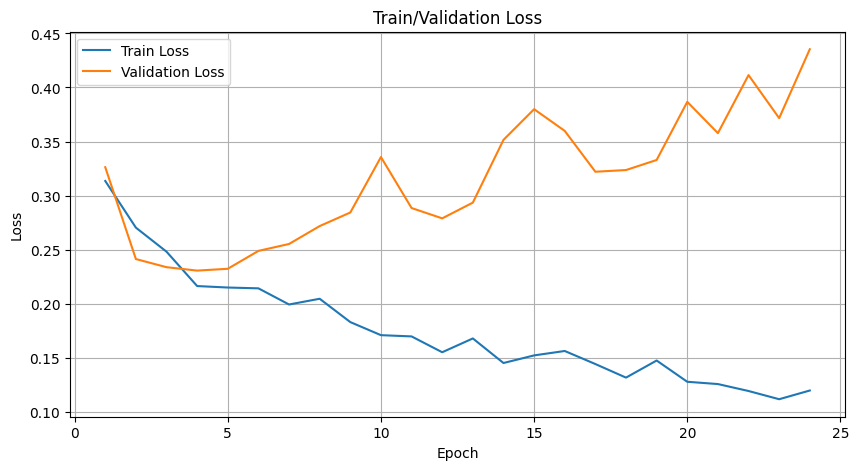

In [6]:
plot_training_history(history)

In [7]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_60_eachtime/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [8]:
output= test_patient_outcome_model(model, test_loader, device)

241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 1816])
99 --- torch.Size([2, 1816])
712 torch.Size([2, 1816])
EDGE_INDEX: torch.Size([2, 1816])		LOOP_INDEX: torch.Size([2, 712])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 2086])
99 --- torch.Size([2, 2086])
753 torch.Size([2, 2086])
EDGE_INDEX: torch.Size([2, 2086])		LOOP_INDEX: torch.Size([2, 753])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1872])
99 --- torch.Size([2, 1872])
688 torch.Size([2, 1872])
EDGE_INDEX: torch.Size([2, 1872])		LOOP_INDEX: torch.Size([2, 688])
241 --- torch.Size([2, 1118])
99 --- torch.Size([2, 1118])
416 torch.Size([2, 1118

In [7]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


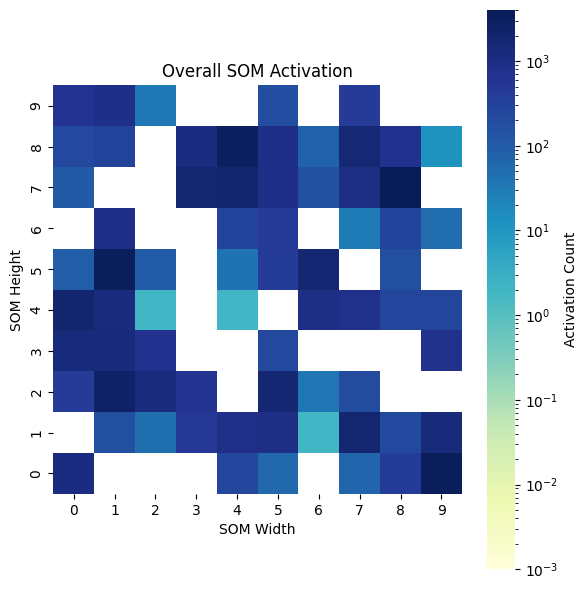

In [8]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

In [9]:
def plot_som_avg_mortality_prob(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        vmin=0.0, vmax=1.0,
        annot=True, fmt=".2f",
        square=True,
        cbar_kws={"label": "Avg Mortality Prob"},
    )
    plt.title("SOM Node Avg Mortality Probability")
    plt.xlabel("SOM Width"); plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

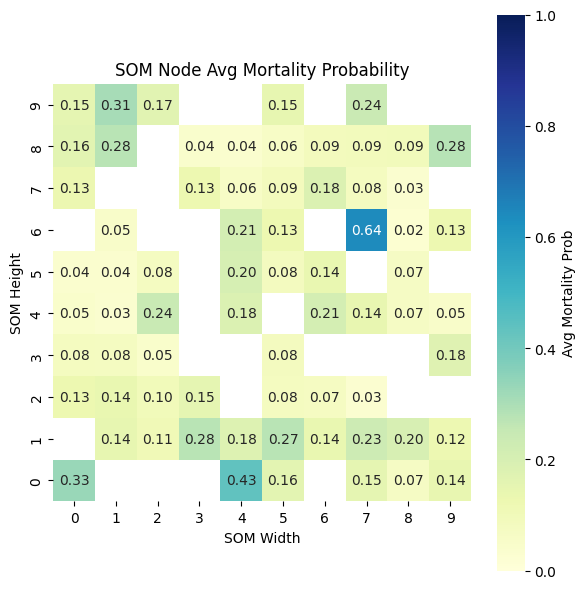

In [10]:
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device, som_dim)
plot_som_avg_mortality_prob(mort_heatmap, som_dim)